In [1]:
!pip install eli5
!pip install pdpbox
!pip install shap
!pip install category_encoders

     |████████████████████████████████| 112kB 2.8MB/s 
     |████████████████████████████████| 57.7MB 69kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690722 sha256=fd8cbb78a3a2d52b55e0014e81236bf8313269f700123369501b69bf40020c24
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox
     |████████████████████████████████| 266kB 2.6MB/s 
  Created wheel for shap: filename=shap-0.34.0-cp36-cp36m-linux_x86_64.whl size=383170 sha256=ac1920a1cf5e16068a41c507b80f57e087c66fdf2681c93af2f5a8dcfe9ac130
  Stored in directory: /root/.cache/pip/wheels/28/7e/28/57bc9fcb77579b0df6561298648249370648c0b91dfe42c8ec
Successfully built shap
     |████████████████████████████████| 102kB 2.4MB/s 


In [2]:
# Number manipulation and plotting imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt


#Training imports
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler


# Analysis imports
import urllib
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from pdpbox.pdp import pdp_isolate, pdp_plot
from eli5.sklearn import PermutationImportance
import shap
import eli5

%matplotlib inline

Using TensorFlow backend.


# EDA

In [0]:
url = 'https://raw.githubusercontent.com/Jllin50/DS-Unit-2-Applied-Modeling/master/AB_NYC_2019.csv'
df = pd.read_csv(url)

In [4]:
#Getting a basic look at the data, shows us that there are null values and gives us an idea of what datatypes we'll be dealing with
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [5]:
#Same as reason as .head() just another angle
df.tail()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2
48894,36487245,Trendy duplex in the very heart of Hell's Kitchen,68119814,Christophe,Manhattan,Hell's Kitchen,40.76404,-73.98933,Private room,90,7,0,NaN,NaN,1,23


In [6]:
#Looking to see how much data and how many features there are  
df.shape

(48895, 16)

In [7]:
#Looking at the datatypes to decide how to encode the data 
df.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [0]:
#Dropping features that obviously have no significant predictive power or features that would require too much cleaning to be useful
df = df.drop(['id', 'name', 'host_id','host_name', 'last_review'], axis=1)

In [9]:
#Looking for null values
df.isnull().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [0]:
#Creating a function to fix the null values
def wrangler(x):
  if x['number_of_reviews'] == 0:
    return 0
  else:
    return x['reviews_per_month']

In [0]:
#Applying the function to the df
df['reviews_per_month'] = df.apply(wrangler, axis=1)

In [12]:
#Making sure the change took effect
df.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [13]:
#Looking for categorical variables with low cardinality
df.nunique()

neighbourhood_group                   5
neighbourhood                       221
latitude                          19048
longitude                         14718
room_type                             3
price                               674
minimum_nights                      109
number_of_reviews                   394
reviews_per_month                   938
calculated_host_listings_count       47
availability_365                    366
dtype: int64

# Visualizations

In [0]:
#Removes the datapoints outliers for better looking visuals
remove_outliers = df[(df.price < 600) & (10 < df.price)]

Text(0.5, 1.0, 'Distribution of prices by Neighborhood Group')

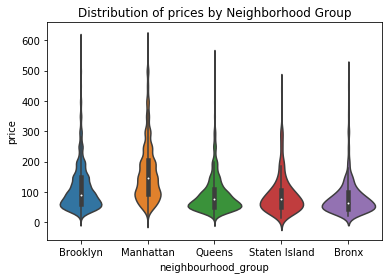

In [15]:
#sns violin
violin=sns.violinplot(data=remove_outliers, x='neighbourhood_group', y='price')
violin.set_title('Distribution of prices by Neighborhood Group')

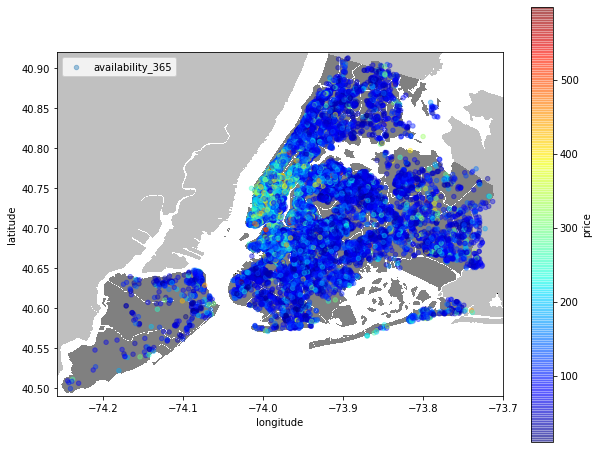

In [16]:
#initializing the figure size
plt.figure(figsize=(10,8))
#loading the png NYC image found on Google
i=urllib.request.urlopen('https://upload.wikimedia.org/wikipedia/commons/e/ec/Neighbourhoods_New_York_City_Map.PNG')
nyc_img=plt.imread(i)
#scaling the image based on the latitude and longitude max and mins for proper output
plt.imshow(nyc_img,zorder=0,extent=[-74.258, -73.7, 40.49,40.92])
ax=plt.gca()
#using scatterplot again
remove_outliers.plot(kind='scatter', x='longitude', y='latitude', label='availability_365', c='price', ax=ax, 
           cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4, zorder=5)
plt.legend()
plt.show()

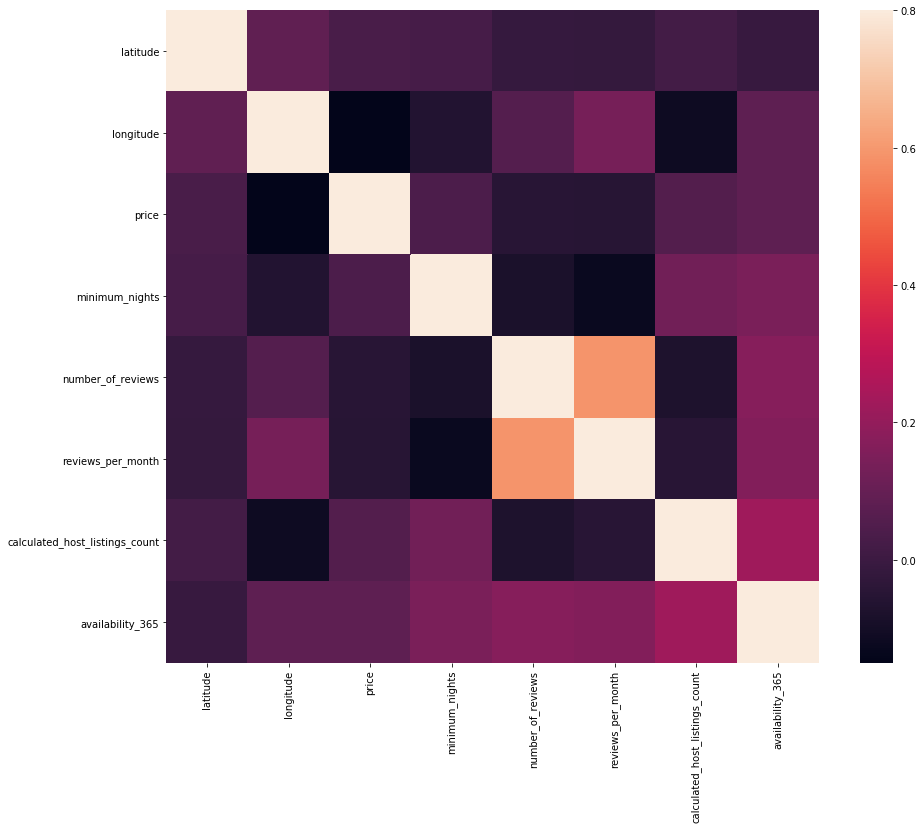

In [17]:
corrmatrix = df.corr()
f, ax = plt.subplots(figsize=(15,12))
sns.heatmap(corrmatrix, vmax=0.8, square=True)
sns.set(font_scale=0.8)

# Formatting the Data for the Model

In [0]:
#Using get_dummites to encode categorical variables
categorical_features = df.select_dtypes(include=['object'])
categorical_features_one_hot = pd.get_dummies(categorical_features)

In [0]:
#creating a seperate df for numeric features
numerical_features =  df.select_dtypes(exclude=['object'])

In [0]:
#rejoining the df's 
df = pd.concat([numerical_features, categorical_features_one_hot], axis=1)

In [0]:
#splitting the data into train, test, and, validation sets
train, test = train_test_split(df, test_size=.2, random_state=42)

In [0]:
train, val = train_test_split(train, test_size=.15, random_state=42)

In [23]:
#Looking at the size of the new dfs
train.shape

(33248, 237)

In [24]:
val.shape

(5868, 237)

In [25]:
test.shape

(9779, 237)

In [0]:
#Isolating the dfs into the model target and x/y sets
target = 'price'
y_train = train[target]
X_train = train.drop(['price'], axis=1)
y_train = train[target]
X_val = val.drop(['price'], axis=1)
y_val = val[target]
X_test = test.drop(['price'],axis=1)
y_test = test[target]

# Mean Baseline

In [27]:
#This shows that if we used the mean to predict the price we have no predictive power
mean_baseline = [y_train.mean()]*len(y_train)
print('R^2 Score:', r2_score(y_train, mean_baseline))

R^2 Score: 0.0


# XGBoost Regression Model

In [28]:
#Using RobustScaler() to scale the data before transforming the data, and finally fitting the data using XGB Regressor
scaler = RobustScaler().fit(X_train)

X_train_transformed = scaler.transform(X_train)
X_val_transformed = scaler.transform(X_val)

model = XGBRegressor(random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

[10:52:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [29]:
#This R2 scores indicates that the model predicts 20% of the data's variance around the mean
y_pred = model.predict(X_val_transformed)


rtwo = r2_score(y_val, y_pred)
print(rtwo)

0.20322338570677523


# Permutation Importance
Here I use the eli5 library to show which features have more of an impact on correctly predicting price. 

In [30]:
#fitting the permuter
permuter = PermutationImportance(
    model, 
    scoring='r2', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                             colsample_bylevel=1,
                                             colsample_bynode=1,
                                             colsample_bytree=1, gamma=0,
                                             importance_type='gain',
                                             learning_rate=0.1,
                                             max_delta_step=0, max_depth=3,
                                             min_child_weight=1, missing=None,
                                             n_estimators=100, n_jobs=-1,
                                             nthread=None,
                                             objective='reg:linear',
                                             random_state=42, reg_alpha=0,
                                             reg_lambda=1, scale_pos_weight=1,
                                     

In [31]:
#gathering the feature names then visualizing it with eli5
feature_names = X_val.columns.tolist()
eli5.show_weights(
    permuter, 
    top=None, # show permutation importances for all features
    feature_names=feature_names # must be a list
)

Weight,Feature
0.4858 ± 0.0500,minimum_nights
0.2130 ± 0.0948,calculated_host_listings_count
0.1861 ± 0.0317,latitude
0.1641 ± 0.0187,room_type_Entire home/apt
0.0987 ± 0.0352,longitude
0.0860 ± 0.0145,availability_365
0.0757 ± 0.0635,neighbourhood_Upper East Side
0.0586 ± 0.0178,neighbourhood_Upper West Side
0.0295 ± 0.0255,neighbourhood_Tribeca
0.0146 ± 0.0052,number_of_reviews


# Removing Features
Here I remove the features that aren't important to speed up future training times and potentially make the model more accurate. 

In [32]:
print('Shape before removing features:', X_train.shape)

Shape before removing features: (33248, 236)


In [0]:
#Removing the features with importance = 0
minimum_importance = 0
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train = X_train[features]
X_val = X_val[features]

In [34]:
print('Shape after removing features:', X_train.shape)

Shape after removing features: (33248, 25)


# Retraining the XGB Regressor

In [35]:
scaler = RobustScaler().fit(X_train)

X_train_transformed = scaler.transform(X_train)
X_val_transformed = scaler.transform(X_val)

model = XGBRegressor(random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

[10:53:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [36]:
#surprisingly the R2 score goes down
y_pred = model.predict(X_val_transformed)


rtwo = r2_score(y_val, y_pred)
print(rtwo)

0.18600089057129587


# Shap Tree Explainer|

In [37]:
#Showing the actual price for this listing
y_test.iloc[[0]]

879    89
Name: price, dtype: int64

In [0]:
#Loading the values of the listing 
row = X_val_transformed[[0]]  

#Predicting the price for this listing with the model
model.predict(row)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

In [39]:
#Visual shows how certain features effect the predicted price 
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,  # across all observations
    shap_values=shap_values,  # the observation we care about right now
    features=X_val.columns
)

# Linear Model

In [0]:
#creating the model
model = LinearRegression()

In [42]:
features = ['availability_365', 
            'number_of_reviews']
print(f'Linear Regression, dependent on: {features}')

X_train = train[features]
X_val = val[features]

Linear Regression, dependent on: ['availability_365', 'number_of_reviews']


In [43]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
y_pred = model.predict(X_val)

In [45]:
#almost no predictive power with this model
rtwo = r2_score(y_val, y_pred)
print(rtwo)

0.011695938272995865
